In [1]:
%run ../notebook_preamble.ipy

In [2]:
import pandas as pd
import pigeonXT as pixt

In [3]:
from sdg_mapping.utils.classifier_utils import IterableDataset, Sample, sort_by_char_len

2021-07-20 08:52:33,411 - faiss.loader - INFO - Loading faiss with AVX2 support.
2021-07-20 08:52:33,653 - faiss.loader - INFO - Successfully loaded faiss with AVX2 support.


In [4]:
import pandas as pd
import os
import transformers
import faiss
import spacy
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from sentence_transformers import SentenceTransformer

In [5]:
from sdg_mapping.utils.annotate_utils import import_collated, clean_annotated_text
from sdg_mapping.cordis.cordis_utils import load_cordis_projects, load_all_cordis_projects

**Option 1**

1. Embed all H2020 projects
2. Put H2020 projects in FAISS index
3. Fetch nearest neighbours of Yes labelled projects (> .8 or 5NN)
4. Add to manually labelled set
5. Select random assortment of other projects
6. Split sentences
7. Label sentences
8. Embed sentences and build classifier

**Option 2**

1. Split sentences of annotated
2. Embed all H2020 sentences
3. Manually label sentences of annotated docs (until ~100 positive examples)
4. Put all embeddings into a FAISS index
5. Create a dataset of 50:50 close positive examples and random examples
6. Create sentence classifier

In [6]:
sts_model = SentenceTransformer('paraphrase-mpnet-base-v2')
clf_model = SentenceTransformer('distilbert-base-cased')

2021-07-20 08:52:35,678 - sentence_transformers.SentenceTransformer - INFO - Load pretrained SentenceTransformer: paraphrase-mpnet-base-v2
2021-07-20 08:52:38,314 - sentence_transformers.SentenceTransformer - INFO - Use pytorch device: cpu
2021-07-20 08:52:38,316 - sentence_transformers.SentenceTransformer - INFO - Load pretrained SentenceTransformer: distilbert-base-cased
2021-07-20 08:52:38,317 - root - WARNING - No sentence-transformers model found with name /home/ubuntu/.cache/torch/sentence_transformers/distilbert-base-cased. Creating a new one with MEAN pooling.


Some weights of the model checkpoint at /home/ubuntu/.cache/torch/sentence_transformers/distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


2021-07-20 08:52:39,418 - sentence_transformers.SentenceTransformer - INFO - Use pytorch device: cpu


In [7]:
# projects = load_all_cordis_projects()
# projects = projects[~pd.isnull(projects['objective'])]

In [12]:
h2020 = load_cordis_projects('h2020')
fp7 = load_cordis_projects('fp7')
projects = pd.concat([h2020, fp7])
projects = projects[~pd.isnull(projects['objective'])]

In [9]:
projects.head()

,rcn,id,acronym,status,programme,topics,framework_programme,title,start_date,end_date,project_url,objective,total_cost,ec_max_contribution,call,funding_scheme,coordinator,coordinator_country,participants,participant_countries
0,228025,891217,CellMechSensE,SIGNED,[H2020-EU.1.3.2.],MSCA-IF-2019,H2020,Cell mechanosensing in the extracellular matrix,2020-04-26,2022-04-25,NaN,"Inside tissues, living cells can adhere to a h...",174806.40,174806.40,H2020-MSCA-IF-2019,MSCA-IF-EF-ST,LUDWIG-MAXIMILIANS-UNIVERSITAET MUENCHEN,DE,NaN,NaN
1,228033,892667,TweeTERS,SIGNED,[H2020-EU.1.3.2.],MSCA-IF-2019,H2020,Coupling of Optical tweezers with Tip-enhanced...,2020-10-01,2022-09-30,NaN,Quantitative information on the dynamics and m...,160932.48,160932.48,H2020-MSCA-IF-2019,MSCA-IF-EF-ST,FUNDACION IMDEA NANOCIENCIA,ES,NaN,NaN
2,228028,892451,EcoScan,SIGNED,[H2020-EU.1.3.2.],MSCA-IF-2019,H2020,guano-based monitoring of ecosystems – a novel...,2020-06-01,2022-05-31,NaN,Climate change is arguably the most pressing c...,184707.84,184707.84,H2020-MSCA-IF-2019,MSCA-IF-EF-ST,INSTITUT NATIONAL DE RECHERCHE POUR L'AGRICULT...,FR,NaN,NaN
3,228027,891826,SEAFLOWER,SIGNED,[H2020-EU.1.3.2.],MSCA-IF-2019,H2020,Strategies for the Exploitation of Anchors for...,2020-07-03,2023-07-02,NaN,Actively taking part to the debate on the futu...,257209.92,257209.92,H2020-MSCA-IF-2019,MSCA-IF-GF,ALMA MATER STUDIORUM - UNIVERSITA DI BOLOGNA,IT,NaN,NaN
4,228030,892010,YouthInMuseums,SIGNED,[H2020-EU.1.3.2.],MSCA-IF-2019,H2020,Educational provision and professional trainin...,2020-09-07,2023-09-06,NaN,This project aims to research the educational ...,239722.56,239722.56,H2020-MSCA-IF-2019,MSCA-IF-EF-CAR,INSTITUTO DE CIENCIAS SOCIAIS,PT,NaN,NaN


In [125]:
# project_sts_encodings = sts_model.encode(list(projects['objective']))

Batches:   0%|          | 0/1685 [00:00<?, ?it/s]

In [10]:
calculate_clf_embeddings = False
if calculate_clf_embeddings:
    project_clf_encodings = clf_model.encode(list(projects['objective']))
    np.save(
        f'{project_dir}/data/interim/fp7_h2020_abstract_encodings_clf', 
        project_clf_encodings)
else:
    project_clf_encodings = np.load(
        f'{project_dir}/data/interim/fp7_h2020_abstract_encodings_clf.npy')

In [13]:
rcn_id_lookup = dict(zip(projects['rcn'], projects.index))

In [14]:
import joblib

In [15]:
from sklearn.utils.class_weight import compute_class_weight
from scipy.stats import lognorm

In [16]:
# class ClassWeights(object):
#     """
#     Draw random variates for cases when parameter is a dict.
#     Should be personalized as needed.
#     """
#     def __init__(self,y, *args, **kwargs):
#         self.class_weights = compute_class_weight("balanced", np.unique(y), y)
#         self._make_dists()

#     def _make_dists(self):
#         self.dist0 = gamma(self.class_weights[0])
#         self.dist1 = gamma(self.class_weights[1])

#     def rvs(self, *args, **kwargs):
#         """override method for drawing random variates"""
#         ret_val = { 0: self.dist0.rvs(*args, **kwargs),
#                     1: self.dist1.rvs(*args, **kwargs)}
#         return ret_val

In [17]:
# from sklearn.pipeline import Pipeline
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import (
    RandomizedSearchCV, cross_validate, StratifiedKFold,
    ShuffleSplit
)
from sklearn.metrics import classification_report


from imblearn.under_sampling import (
    AllKNN, RepeatedEditedNearestNeighbours)
from imblearn.over_sampling import SMOTE, KMeansSMOTE
from imblearn.pipeline import Pipeline
from imblearn.ensemble import BalancedRandomForestClassifier

from xgboost.sklearn import XGBClassifier
from scipy.stats import uniform, loguniform, truncnorm, randint

from operator import itemgetter

In [13]:
def make_sdg_encodings(sdg):
    sdg_df = import_collated(sdg)
    encodings = clf_model.encode(list(sdg_df['abstract']))
    labels = sdg_df['Label'].map({'Yes': 1, 'No': 0})
    return encodings, labels

In [79]:
for sdg in range(1, 17):
    encodings, labels = make_sdg_encodings(sdg)
    sdg = str(sdg).zfill(2)
    np.save(
        f'{project_dir}/data/raw/annotated/collated/distilbert_{sdg}', 
        encodings)

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/37 [00:00<?, ?it/s]

Batches:   0%|          | 0/35 [00:00<?, ?it/s]

Batches:   0%|          | 0/33 [00:00<?, ?it/s]

Batches:   0%|          | 0/35 [00:00<?, ?it/s]

Batches:   0%|          | 0/41 [00:00<?, ?it/s]

Batches:   0%|          | 0/35 [00:00<?, ?it/s]

Batches:   0%|          | 0/36 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/40 [00:00<?, ?it/s]

Batches:   0%|          | 0/33 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/37 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/34 [00:00<?, ?it/s]

In [18]:
def get_sdg_encodings(sdg):
    sdg_df = import_collated(sdg)
    sdg = str(sdg).zfill(2)
    enc_fname = f'{project_dir}/data/raw/annotated/collated/distilbert_{sdg}.npy'
    encodings = np.load(enc_fname)
    labels = sdg_df['Label'].map({'Yes': 1, 'No': 0})
    return encodings, labels

In [22]:
for sdg in range(1, 17):
    sdg_df = import_collated(sdg)
    labels = sdg_df['Label'].map({'Yes': 1, 'No': 0})
    pc_pos = labels.sum() / len(labels)
    print(sdg, pc_pos * 100)

1 6.988188976377953
2 17.368873602751506
3 40.974729241877256
4 17.641418983700863
5 13.989169675090253
6 26.381322957198446
7 23.634735899731425
8 33.65810451727192
9 24.578790882061448
10 14.313919052319843
11 26.08
12 23.704414587332053
13 12.254901960784313
14 24.47078746824725
15 23.799999999999997
16 24.141132776230272


In [23]:
lt_15 = [1, 5, 10, 13]
lt_20 = [1, 2, 4, 5, 10, 13]

In [75]:
from sklearn.linear_model import LogisticRegression
from sdg_mapping.utils.sdg_utils import sdg_names

In [79]:
for sdg in range(1, 17):
    encodings, labels = get_sdg_encodings(sdg)
    
    X_train, X_test, y_train, y_test = train_test_split(encodings, labels, test_size=0.2)
    
    lr = LogisticRegression(max_iter=5000)
#     rfc = RandomForestClassifier(class_weight='balanced')
    
    lr.fit(X_train, y_train)
    print(sdg_names()[sdg])
    print(classification_report(y_test, lr.predict(X_test)), '\n')

1. No Poverty
              precision    recall  f1-score   support

           0       0.94      0.98      0.96       190
           1       0.40      0.14      0.21        14

    accuracy                           0.93       204
   macro avg       0.67      0.56      0.59       204
weighted avg       0.90      0.93      0.91       204
 

2. Zero Hunger
              precision    recall  f1-score   support

           0       0.88      0.92      0.90       188
           1       0.59      0.49      0.54        45

    accuracy                           0.84       233
   macro avg       0.74      0.70      0.72       233
weighted avg       0.83      0.84      0.83       233
 

3. Good Health & Well-being
              precision    recall  f1-score   support

           0       0.89      0.90      0.89       125
           1       0.86      0.86      0.86        97

    accuracy                           0.88       222
   macro avg       0.88      0.88      0.88       222
weighted avg 

In [80]:
from sklearn.feature_selection import SelectKBest

In [125]:
import time

In [138]:
best_models = {}
best_params = {}

for sdg in range(1, 17):
    start = time.time()
    encodings, labels = get_sdg_encodings(sdg)
    X_train, X_test, y_train, y_test = train_test_split(
        encodings, labels, test_size=0.2, random_state=99)
    
    pipe = Pipeline([
        ('xgb', XGBClassifier(use_label_encoder=False, eval_metric='auc', num_parallel_tree=4))
    ])

    pos_weight = (y_train.shape[0] - y_train.sum()) / y_train.sum()
    min_weight = pos_weight - (.3 * pos_weight)
    max_weight = pos_weight + (.3 * pos_weight)

    min_sample_ratio = 1 / pos_weight

    param_space = {
        'xgb__eta': loguniform(0.01, 1),
        'xgb__gamma': uniform(0, 10),
        'xgb__max_depth' : randint(3, 10),
        'xgb__scale_pos_weight': uniform(min_weight, max_weight),
        'xgb__min_child_weight': uniform(0, 100),
        'xgb__max_delta_step': uniform(0, 10),
        'xgb__sampling_method': ['uniform', 'gradient_based'],
        'xgb__colsample_bytree': uniform(0, 1), 
        'xgb__colsample_bylevel': uniform(0, 1), 
        'xgb__colsample_bynode': uniform(0, 1), 
    }
    
    clf = RandomizedSearchCV(
        pipe, 
        param_distributions=param_space, 
        n_iter=256, 
        scoring='roc_auc',
        cv=StratifiedKFold(n_splits=3, shuffle=True),
        verbose=1
    )
    
    clf.fit(X_train, y_train)
    end = time.time()
    duration = (end - start) / 60
    
    print('===', sdg_names()[sdg], '===')
    print(f'Took {duration} mins')
    print(classification_report(y_test, clf.best_estimator_.predict(X_test)))
    
    best_models[sdg] = clf.best_estimator_
    best_params[sdg] = clf.best_params_

Fitting 3 folds for each of 256 candidates, totalling 768 fits
=== 1. No Poverty ===
Took 3.799406588077545 mins
              precision    recall  f1-score   support

           0       0.97      0.96      0.96       186
           1       0.62      0.72      0.67        18

    accuracy                           0.94       204
   macro avg       0.80      0.84      0.82       204
weighted avg       0.94      0.94      0.94       204

Fitting 3 folds for each of 256 candidates, totalling 768 fits
=== 2. Zero Hunger ===
Took 4.435634557406107 mins
              precision    recall  f1-score   support

           0       0.95      0.86      0.91       194
           1       0.53      0.79      0.64        39

    accuracy                           0.85       233
   macro avg       0.74      0.83      0.77       233
weighted avg       0.88      0.85      0.86       233

Fitting 3 folds for each of 256 candidates, totalling 768 fits
=== 3. Good Health & Well-being ===
Took 3.5250081260999

In [180]:
def get_result_type_indices(labels, predictions, result_type='tp'):
    if result_type == 'tp':
        mask = ((labels == 1) & (predictions == 1))
    elif result_type == 'fp':
        mask = ((labels == 0) & (predictions == 1))
    elif result_type == 'tn':
        mask = ((labels == 0) & (predictions == 0))
    elif result_type == 'fn':
        mask = ((labels == 1) & (predictions == 0))
    
    indices = labels[mask == True].index
    
    return np.array(indices)

In [193]:
def get_result_type_samples(sdg, labels, predictions, result_type='tp', n=None, random_state=None):
    sdg_df = import_collated(sdg)
    indices = get_result_type_indices(labels, predictions, result_type)
    
    sdg_df = sdg_df.loc[indices]
    if (n is not None) and (n <= sdg_df.shape[0]):
        sdg_df = sdg_df.sample(n, random_state=random_state)

    return sdg_df.to_dict(orient='records')

In [208]:
for sdg in range(1, 17):

    encodings, labels = get_sdg_encodings(sdg)
    X_train, X_test, y_train, y_test = train_test_split(
        encodings, labels, test_size=0.2, random_state=99)

    model = best_models[sdg]
    preds = model.predict(X_test)

    sdg_df = import_collated(sdg)
    test_df = sdg_df.iloc[y_test.index]

    test_df['predicted'] = preds
    test_df['label'] = y_test
    
    test_df.to_csv(f'{project_dir}/data/processed/sdg_model/{str(sdg).zfill(2)}_test_predictions.csv')

    # samples = get_result_type_samples(sdg, y_test, preds, result_type='fp', n=10)

    # for s in samples:
    #     print(s['title'], '\n')

/home/ubuntu/anaconda3/envs/sdg_mapping/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/ubuntu/anaconda3/envs/sdg_mapping/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [211]:
import joblib

In [213]:
full_preds = {'rcn': np.array(projects['rcn'])}
full_clfs = {}

for sdg in range(1, 17):
    clf = best_models[sdg]
    encodings, labels = get_sdg_encodings(sdg)
    clf.fit(encodings, labels)
    full_clfs[sdg] = clf
    
    full_preds[sdg] = clf.predict(project_clf_encodings)

In [218]:
for sdg, model in full_clfs.items():
    sdg = str(sdg).zfill(2)
    with open(f'{project_dir}/models/sdg_{sdg}.pkl', 'wb') as f:
        joblib.dump(model, f)

In [222]:
preds_df = pd.DataFrame(full_preds)
preds_df.to_csv(f'{project_dir}/data/processed/h2020_fp7_sdg_predictions.csv', index=False)

In [224]:
projects.set_index('rcn').loc[preds_df[preds_df[15] == 1]['rcn']].sample(10)['title']

rcn
215789    Impacts of the North Atlantic Decadal variabil...
201523    Evaluating the performance of local climate po...
97903     Support EO-driven forest and carbon monitoring...
111232    Making society an active participant in water ...
197517    Maintenance of species diversity and the stabi...
205314    Indigenous Communities, Land Use and Tropical ...
109120             CACHE: CAlcium in a CHanging Environment
215365    Predicting the impacts of climate change and m...
99386     Molecular basis of beneficial plant-endophyte ...
202666    Probabilistic Nowcasting of Winter Weather for...
Name: title, dtype: object

In [225]:
from sklearn.decomposition import TruncatedSVD
from umap import UMAP

In [226]:
def umapify(vectors):
    svd_transformer = TruncatedSVD(n_components=30)
    svd_vecs = svd_transformer.fit_transform(vectors)
    umap_transformer = UMAP(n_components=2)
    umap_vecs = umap_transformer.fit_transform(svd_vecs)
    return umap_vecs

In [293]:
project_sts_encodings = np.load(f'{project_dir}/data/interim/fp7_h2020_abstract_sent_encodings_sts.npy')

In [296]:
umap_vecs = umapify(project_clf_encodings)

In [237]:
from sdg_mapping.utils.sdg_utils import sdg_hex_color_codes

In [284]:
sdg_colors = sdg_hex_color_codes()
sdg_colors[0] = '#efefef'

In [245]:
preds_df = preds_df.reset_index()

In [250]:
single_goal_ids = preds_df[preds_df[list(range(1, 17))].sum(axis=1) <= 1].index

In [264]:
single_goals_df = preds_df.loc[single_goal_ids][list(range(1, 17))]
single_goals_df[0] = [1 if x == 0 else 0 for x in single_goals_df.sum(axis=1)]

In [287]:
single_goals_df = single_goals_df.idxmax(axis=1).sort_values()

In [291]:
single_goal_ids = single_goals_df.index

In [290]:
colors = single_goals_df.map(sdg_colors)

2021-07-20 16:43:17,640 - matplotlib.legend - WARNING - No handles with labels found to put in legend.


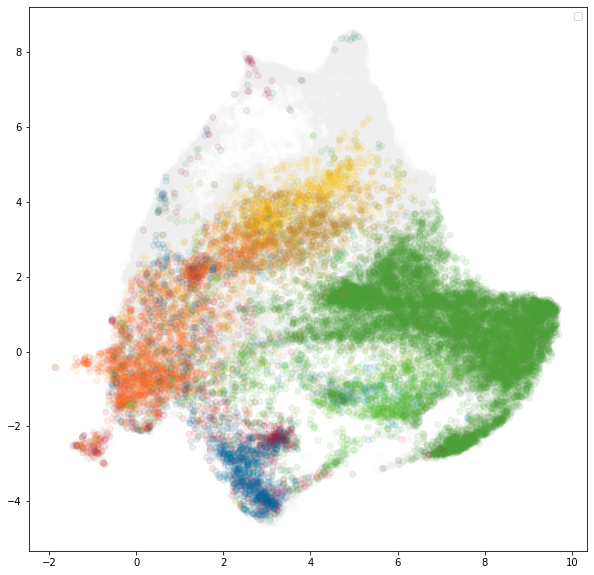

In [298]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(umap_vecs[single_goal_ids, 0], umap_vecs[single_goal_ids, 1], alpha=.1, c=colors)

In [133]:
splitter = ShuffleSplit(n_splits=1, test_size=.2)
# X_train_ids, X_test_ids, y_train_ids, y_test_ids = splitter.split(
split_ids = splitter.split(
    encodings
)
train_ids, test_ids = 

# X_train, X_test, y_train, y_test = train_test_split(
#     encodings, labels, test_size=.2
# )

In [ ]:
def get_type_examples(samples, y_true, y_pred, prediction_type='fn'):
    if prediction_type = 'tp':
        ids = np.argwhere()

In [94]:
from yellowbrick.classifier import ROCAUC

In [92]:
clf.best_estimator_.predict_proba(X_test)

array([[9.25196350e-01, 7.48036355e-02],
       [9.99981821e-01, 1.81588548e-05],
       [5.60950160e-01, 4.39049810e-01],
       [9.94809866e-01, 5.19014616e-03],
       [9.99669135e-01, 3.30891955e-04],
       [9.99740779e-01, 2.59201013e-04],
       [9.99845684e-01, 1.54329828e-04],
       [9.99298394e-01, 7.01592769e-04],
       [9.99940336e-01, 5.96577593e-05],
       [9.99972343e-01, 2.76652172e-05],
       [9.99973476e-01, 2.65204199e-05],
       [9.76366103e-01, 2.36338917e-02],
       [9.99966562e-01, 3.34289107e-05],
       [9.99950171e-01, 4.98264053e-05],
       [9.63060319e-01, 3.69396806e-02],
       [9.13759887e-01, 8.62400979e-02],
       [9.09233868e-01, 9.07661542e-02],
       [9.76874053e-01, 2.31259260e-02],
       [9.99439299e-01, 5.60695247e-04],
       [5.64812183e-01, 4.35187846e-01],
       [9.99411106e-01, 5.88888535e-04],
       [9.99253511e-01, 7.46516453e-04],
       [9.99945641e-01, 5.43372771e-05],
       [9.99982893e-01, 1.71346292e-05],
       [7.369413

2021-07-18 15:50:55,301 - numexpr.utils - INFO - Note: NumExpr detected 32 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2021-07-18 15:50:55,302 - numexpr.utils - INFO - NumExpr defaulting to 8 threads.


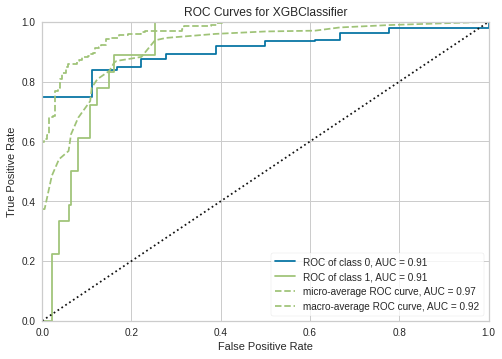

<AxesSubplot:title={'center':'ROC Curves for XGBClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [96]:
visualiser = ROCAUC(clf.best_estimator_, classes=[0, 1])
visualiser.fit(X_train, y_train)
visualiser.score(X_test, y_test)
visualiser.show()

In [97]:
from yellowbrick.classifier import DiscriminationThreshold

/home/ubuntu/anaconda3/envs/sdg_mapping/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:52:48] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/ubuntu/anaconda3/envs/sdg_mapping/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:52:48] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/ubuntu/anaconda3/envs/sdg_mapping/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:52:49] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/ubuntu/anaconda3/envs/sdg_mapping/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:52:49] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/ubuntu/anaconda3/envs/sdg_mapping/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:52:49] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/ubuntu/anaconda3/envs/sdg_mapping/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:52:50] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/ubuntu/anaconda3/envs/sdg_mapping/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:52:50] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/ubuntu/anaconda3/envs/sdg_mapping/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:52:51] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/ubuntu/anaconda3/envs/sdg_mapping/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:52:51] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/ubuntu/anaconda3/envs/sdg_mapping/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:52:51] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/ubuntu/anaconda3/envs/sdg_mapping/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:52:52] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/ubuntu/anaconda3/envs/sdg_mapping/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:52:52] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/ubuntu/anaconda3/envs/sdg_mapping/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:52:52] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/ubuntu/anaconda3/envs/sdg_mapping/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:52:53] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/ubuntu/anaconda3/envs/sdg_mapping/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:52:53] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/ubuntu/anaconda3/envs/sdg_mapping/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:52:53] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/ubuntu/anaconda3/envs/sdg_mapping/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:52:54] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/ubuntu/anaconda3/envs/sdg_mapping/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:52:54] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/ubuntu/anaconda3/envs/sdg_mapping/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:52:55] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/ubuntu/anaconda3/envs/sdg_mapping/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:52:55] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/ubuntu/anaconda3/envs/sdg_mapping/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:52:55] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/ubuntu/anaconda3/envs/sdg_mapping/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:52:56] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/ubuntu/anaconda3/envs/sdg_mapping/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:52:56] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/ubuntu/anaconda3/envs/sdg_mapping/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:52:56] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/ubuntu/anaconda3/envs/sdg_mapping/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:52:57] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/ubuntu/anaconda3/envs/sdg_mapping/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:52:57] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/ubuntu/anaconda3/envs/sdg_mapping/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:52:57] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/ubuntu/anaconda3/envs/sdg_mapping/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:52:58] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/ubuntu/anaconda3/envs/sdg_mapping/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:52:58] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/ubuntu/anaconda3/envs/sdg_mapping/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:52:59] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/ubuntu/anaconda3/envs/sdg_mapping/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:52:59] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/ubuntu/anaconda3/envs/sdg_mapping/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:52:59] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/ubuntu/anaconda3/envs/sdg_mapping/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:53:00] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/ubuntu/anaconda3/envs/sdg_mapping/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:53:00] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/ubuntu/anaconda3/envs/sdg_mapping/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:53:00] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/ubuntu/anaconda3/envs/sdg_mapping/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:53:01] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/ubuntu/anaconda3/envs/sdg_mapping/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:53:01] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/ubuntu/anaconda3/envs/sdg_mapping/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:53:01] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/ubuntu/anaconda3/envs/sdg_mapping/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:53:02] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/ubuntu/anaconda3/envs/sdg_mapping/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:53:02] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/ubuntu/anaconda3/envs/sdg_mapping/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:53:03] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/ubuntu/anaconda3/envs/sdg_mapping/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:53:03] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/ubuntu/anaconda3/envs/sdg_mapping/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:53:03] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/ubuntu/anaconda3/envs/sdg_mapping/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:53:04] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/ubuntu/anaconda3/envs/sdg_mapping/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:53:04] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/ubuntu/anaconda3/envs/sdg_mapping/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:53:04] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/ubuntu/anaconda3/envs/sdg_mapping/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:53:05] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/ubuntu/anaconda3/envs/sdg_mapping/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:53:05] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/ubuntu/anaconda3/envs/sdg_mapping/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:53:06] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/ubuntu/anaconda3/envs/sdg_mapping/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:53:06] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


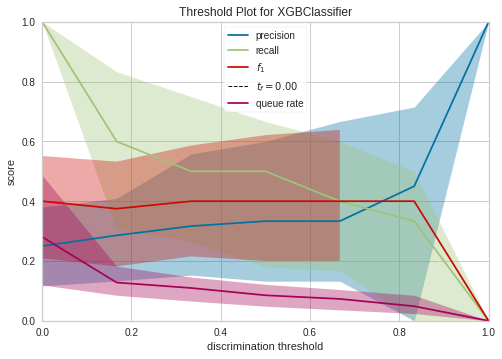

<AxesSubplot:title={'center':'Threshold Plot for XGBClassifier'}, xlabel='discrimination threshold', ylabel='score'>

In [99]:
model = clf.best_estimator_
visualizer = DiscriminationThreshold(model)

visualizer.fit(X_train, y_train)        # Fit the data to the visualizer
visualizer.show()           # Finalize and render the figure

In [76]:
k_fold = StratifiedKFold(n_splits=5, shuffle=True)
cross_validate(pipe, encodings, y=labels, scoring='f1', cv=k_fold)

/home/ubuntu/anaconda3/envs/sdg_mapping/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:20:29] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/ubuntu/anaconda3/envs/sdg_mapping/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:20:30] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/ubuntu/anaconda3/envs/sdg_mapping/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:20:31] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/ubuntu/anaconda3/envs/sdg_mapping/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:20:32] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/ubuntu/anaconda3/envs/sdg_mapping/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:20:33] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


{'fit_time': array([0.74520326, 0.81705952, 0.74689007, 0.77373743, 0.82004929]),
 'score_time': array([0.00417876, 0.00423288, 0.00436735, 0.00420594, 0.00419545]),
 'test_score': array([0.48275862, 0.48648649, 0.        , 0.2       , 0.41176471])}

In [20]:
X_train, X_test, y_train, y_test = train_test_split(
    encodings, labels, test_size=0.2)
pipe.fit(X_train, y_train)

/home/ubuntu/anaconda3/envs/sdg_mapping/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:07:45] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Pipeline(steps=[('svd', TruncatedSVD(n_components=200)),
                ('allknn', AllKNN(n_neighbors=2, sampling_strategy='majority')),
                ('smote', SMOTE(sampling_strategy='minority')),
                ('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=6, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=32, num_parallel_tree=1, random_state=0,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                               subsample=1, tree_method='exact',
 

In [21]:
print(classification_report(y_test, pipe.predict(X_test)))

              precision    recall  f1-score   support

           0       0.97      0.94      0.95       194
           1       0.25      0.40      0.31        10

    accuracy                           0.91       204
   macro avg       0.61      0.67      0.63       204
weighted avg       0.93      0.91      0.92       204



In [40]:
import random

[105827, 100495, 211016, 88139, 213063, 94250, 89101, 227516, 200433, 100552]

In [43]:
itemgetter(*random.sample(rcn_id_lookup.keys(), 10))(rcn_id_lookup)

(14438, 17362, 10182, 15450, 19986, 2967, 237, 24496, 15448, 4567)

In [36]:
get_sdg_encodings(1)

KeyError: 43935

In [153]:
fname = f'{project_dir}/data/interim/fp7_h2020_abstract_rcn_lookup.pkl'

with open(fname, 'wb') as f:
    joblib.dump(rcn_id_lookup, f)

In [126]:
d = project_sts_encodings.shape[1]
project_sts_index = faiss.IndexFlatL2(d)
project_sts_index.add(project_sts_encodings)

In [128]:
projects = projects.reset_index()

In [130]:
sdg_ids = {}

for sdg in range(1, 2):
    sample_ids = []
    sdg_df = import_collated(sdg)
    yes_rcns = list(sdg_df[sdg_df['Label'] == 'Yes']['ID'])
    yes_ids = projects[projects['rcn'].isin(yes_rcns)].index
    yes_encodings = project_sts_encodings[yes_ids]
#     for chunk in chunker(yes_encodings, chunk_size):
#         _, i = index.search(chunk, k)
#         nns = i[0]
#         for sample_nns in nns:
#             sample_ids.append(sample_nns)
#     sdg_sent_sample_record_ids[sdg] = sample_ids

In [132]:
yes_ids

Int64Index([   29,   327,  1461,  1811,  2890,  4236,  4782,  5281,  6432,
             6727,  7182,  9908, 10613, 11705, 14007, 14250, 15205, 15318,
            17436, 18370, 19814, 19876, 25493, 26754, 26888, 28629, 30866,
            31269, 32644, 32656, 34229, 34419, 34435, 40859, 42382, 42485,
            43263, 44825, 44877, 45608, 45799, 46483, 48032, 48661, 49671,
            50623],
           dtype='int64')

In [9]:
import spacy

In [16]:
def chunker(lst, n):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

In [10]:
nlp = spacy.load('en_core_web_md')

In [11]:
abstracts = list(zip(projects['objective'], projects['rcn']))

In [123]:
project_sent_records = []

pipe = nlp.pipe(
    abstracts, 
    as_tuples=True,
    disable=["tagger", "attribute_ruler", "lemmatizer"],
    n_process=30
)

for doc, doc_id in pipe:
    sents = []
    for s in doc.sents:
        if len(s.text.strip()) > 5:
            sents.append(s.text.strip())
        for chunk in chunker(sents, 3):
            project_sent_records.append(
                {'id': doc_id, 'text': ' '.join(chunk)}
            )

In [124]:
len(project_sent_records)

1283539

In [13]:
calculate_embeddings = True
if calculate_embeddings:
    project_encodings = sts_model.encode(list([t['text'] for t in project_sent_records]))
    np.save(f'{project_dir}/data/interim/fp7_h2020_abstract_sent_chunk_encodings_sts', project_encodings)
else:
    project_encodings = np.load(f'{project_dir}/data/interim/fp7_h2020_abstract_sent_chunk_encodings_sts.npy')

In [14]:
import faiss

In [15]:
d = project_encodings.shape[1]
index = faiss.IndexFlatL2(d)
index.add(project_encodings)

In [116]:
chunk_size = 5
k = 50

sdg_sent_sample_record_ids = {}

for sdg in range(1, 17):
    sample_ids = []
    sdg_df = import_collated(sdg)
    yes_abstracts = sdg_df[sdg_df['Label'] == 'Yes']['abstract']
    yes_encodings = sts_model.encode(list(yes_abstracts))
    for chunk in chunker(yes_encodings, chunk_size):
        _, i = index.search(chunk, k)
        nns = i[0]
        for sample_nns in nns:
            sample_ids.append(sample_nns)
    sdg_sent_sample_record_ids[sdg] = sample_ids

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/15 [00:00<?, ?it/s]

Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/11 [00:00<?, ?it/s]

Batches:   0%|          | 0/9 [00:00<?, ?it/s]

Batches:   0%|          | 0/12 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/11 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/9 [00:00<?, ?it/s]

In [118]:
for k, v in sdg_sent_sample_record_ids.items():
    sdg_sent_sample_record_ids[k] = set(v)
    print(len(v))

701
1801
4231
1634
1044
2102
2250
3060
2070
1258
2651
2310
1145
2156
2156
2305


In [119]:
n = 1000

sampled_sent_ids = {}

for k, v in sdg_sent_sample_record_ids.items():
    if len(v) < n:
        sampled_sent_ids[k] = list(v)
    else:
        sampled_sent_ids[k] = random.sample(list(v), n)

In [120]:
all_sdg_sample_records = []
done = []

for k, v in sampled_sent_ids.items():
    for item in v:
        if item not in done:
            record = {'sent_id': item,
                      'sdg': k,
                      **project_sent_records[item]}
            all_sdg_sample_records.append(record)
            done.append(item)

In [97]:
all_sdg_sample_records[20000]

{'sent_id': 131476,
 'sdg': 16,
 'id': 215586,
 'text': 'This project aims to fill this gap and inform policymakers by comparing different fiscal consolidation instruments: (a) labour income tax hikes, (b) public consumption spending cuts, (c) unemployment benefits cuts, and (d) public sector wage bill cuts.'}

In [122]:
random.sample(all_sdg_sample_records, 2)

[{'sent_id': 352541,
  'sdg': 13,
  'id': 95785,
  'text': 'Recent global recognition of the serious and immediate threats facing marine ecosystems has led to concerns regarding the loss of biodiversity within these systems.'},
 {'sent_id': 126185,
  'sdg': 3,
  'id': 215661,
  'text': 'My research builds on emerging data showing the molecular machinery for microRNAs - short non-coding RNAs that regulate gene expression post-transcriptionally by targeting mRNAs - is present locally, within astrocyte processes.'}]

In [76]:
sdg_ids = list(set(chain(*sampled_sent_ids.values())))

In [45]:
from itertools import chain
from collections import Counter

In [33]:
sdg_sent_sample_record_ids

[429441,
 488783,
 285364,
 425894,
 500782,
 463280,
 284379,
 420470,
 507300,
 314947,
 284372,
 284542,
 458130,
 112029,
 306115,
 288040,
 112026,
 38904,
 124263,
 94616,
 124261,
 526156,
 466523,
 507297,
 302220,
 341072,
 284371,
 361358,
 55571,
 206922,
 149949,
 474292,
 511868,
 488788,
 179246,
 154832,
 452530,
 226777,
 426540,
 301945,
 59735,
 323161,
 162560,
 531377,
 396968,
 285360,
 44299,
 417272,
 296173,
 301948,
 306120,
 239712,
 208554,
 248936,
 282126,
 159865,
 526155,
 429446,
 488789,
 467510,
 505457,
 219341,
 284548,
 154405,
 134833,
 124260,
 161795,
 52792,
 304967,
 205561,
 412414,
 52787,
 39820,
 44292,
 212075,
 149085,
 429448,
 112024,
 470064,
 328058,
 520412,
 15383,
 161793,
 121095,
 255136,
 214457,
 52785,
 275925,
 337461,
 38907,
 210526,
 211541,
 488784,
 520414,
 301358,
 511869,
 169635,
 350862,
 323164,
 350866,
 270001,
 314205,
 270009,
 350361,
 314361,
 355167,
 167977,
 428744,
 403091,
 122722,
 249553,
 311506,
 563

In [169]:
sdg_df['abstract'][1000]

'The future European emission standards (EURO IV and EURO V) for HD diesel engines demand new truck engine technologies such as an exhaust gas recirculation (EGR), variable nozzle turbocharger (VNT) and exhaust gas after treatment systems. EGR and VNT do influence one another via the exhaust flow and exhaust backpressure. Therefore, within transient operation, a high precision control of EGR and VNT is required to avoid smoke and/or NOx emission peaks. The objective of the proposed project is a research program focusing on a new Advanced Truck Engine Control System ATECS including new strategies for engine control and ECU (electronic control unit) calibration as well as an uncoupling control strategy for EGR and VNT. To achieve this, two European truck engine manufacturers, two suppliers, four university institutes and one combustion engine development company, as co-ordinator will co-operate close together. The expected results are advanced truck engine control strategies for reduced 

In [30]:
for a in i[0]:
    print(project_sent_records[a]['text'])
    print(project_sent_records[a]['text'] in sdg_df['abstract'][1000])
    print()

The overall ambition of the PIE News project is to foster the emergence of commonfare as an alternative economic model to fight poverty, a condition affecting some 25% of the European population.
False

The project pioneers commonfare as a new social innovation goal by raising collective awareness on the threats connected to Poverty, lack of Income, and unEmployment (‘PIE conditions’), thus empowering the new poor and enabling the relevant stakeholders, e.g. polivcy makers, to tackle such threats more effectively.
False

Commonfare is a new collaborative form of welfare provision based on equitable governance and grassroots democracy.
False

PIE NEWS capitalizes on the collective power and skills of the ‘new poor’ promoting commonfare through actions that increase collective awareness on PIE Conditions.
False

The consortium will achieve this goal through a Collective Awareness Platform (CAPS) which (a) informs people about existing welfare state provisions, (b) provides them with the 

In [9]:
from sdg_mapping.utils.sdg_utils import sdg_names

In [10]:
annotated_sts_encodings = {}

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/37 [00:00<?, ?it/s]

Batches:   0%|          | 0/35 [00:00<?, ?it/s]

Batches:   0%|          | 0/33 [00:00<?, ?it/s]

Batches:   0%|          | 0/35 [00:00<?, ?it/s]

Batches:   0%|          | 0/41 [00:00<?, ?it/s]

Batches:   0%|          | 0/35 [00:00<?, ?it/s]

Batches:   0%|          | 0/36 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/40 [00:00<?, ?it/s]

Batches:   0%|          | 0/33 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/37 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/34 [00:00<?, ?it/s]

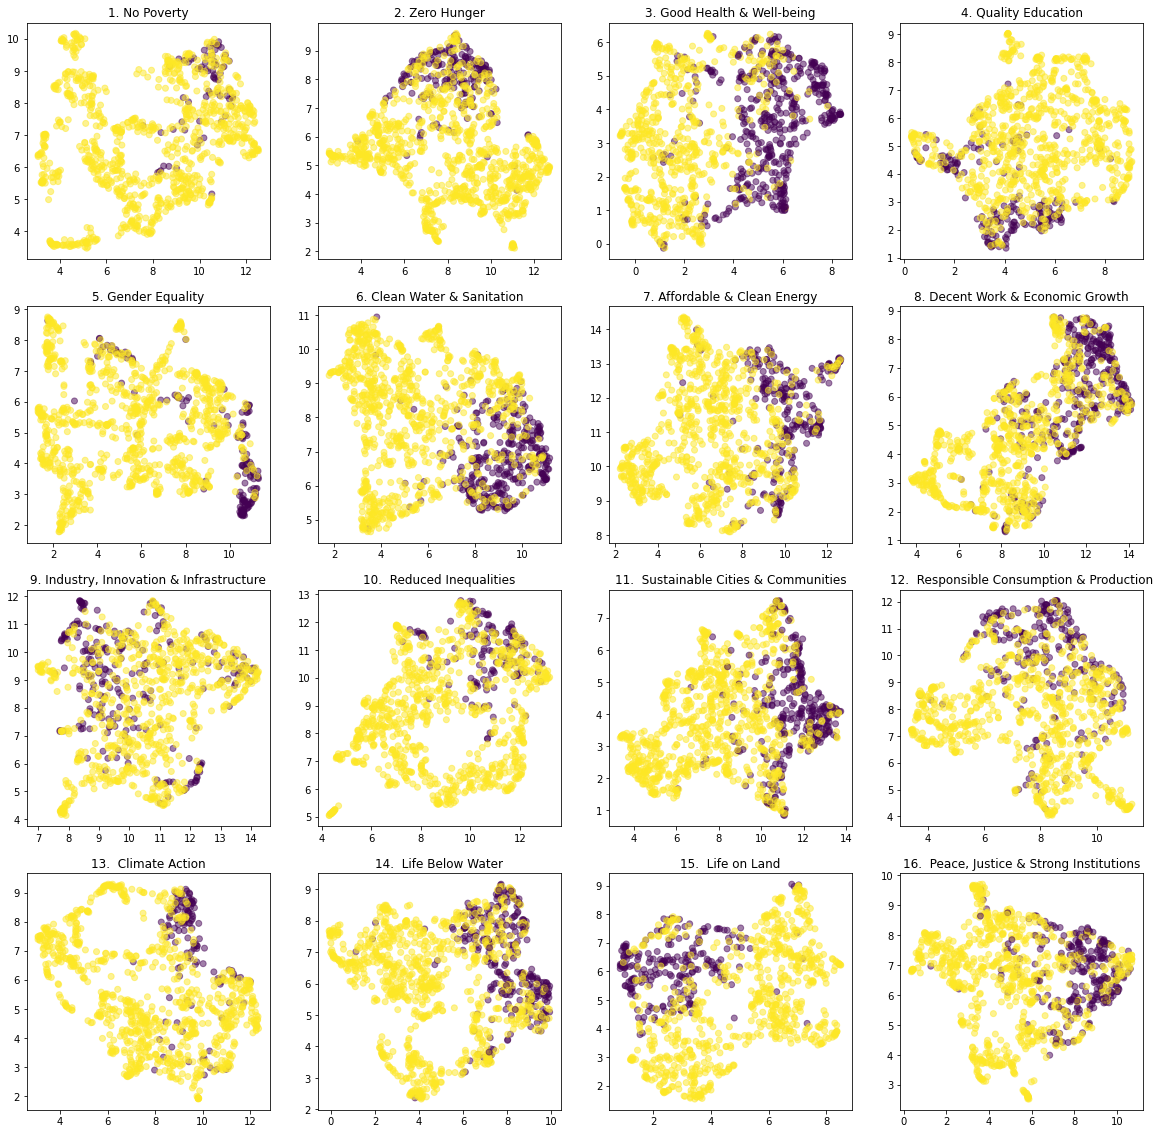

In [40]:
fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(20, 20))

for ax, sdg in zip(axs.ravel(), range(1, 17)):
    if sdg not in annotated_sts_encodings:
        sdg_df = import_collated(sdg)
        encodings = sts_model.encode(sdg_df['abstract'])
        annotated_sts_encodings[sdg] = encodings
    umap_vecs = umapify(encodings)
    ax.scatter(umap_vecs[:, 0], umap_vecs[:, 1], 
                c=[0 if l == 'Yes' else 1 for l in sdg_df['Label']], alpha=.5)
    ax.set_title(sdg_names()[sdg])

In [104]:
from sklearn.model_selection import GridSearchCV

In [106]:
clf_model = SentenceTransformer('bert-base-cased')

2021-07-17 14:56:37,922 - sentence_transformers.SentenceTransformer - INFO - Load pretrained SentenceTransformer: bert-base-cased
2021-07-17 14:56:38,281 - filelock - INFO - Lock 139712966225200 acquired on /home/ubuntu/.cache/torch/sentence_transformers/bert-base-cased.af58a380c064c47fd786e7512655f521d13f9220/.gitattributes.lock
2021-07-17 14:56:38,282 - huggingface_hub.file_download - INFO - downloading https://huggingface.co/bert-base-cased/resolve/af58a380c064c47fd786e7512655f521d13f9220/.gitattributes to /home/ubuntu/.cache/torch/sentence_transformers/bert-base-cased.af58a380c064c47fd786e7512655f521d13f9220/tmptvizii04


Downloading:   0%|          | 0.00/437 [00:00<?, ?B/s]

2021-07-17 14:56:38,372 - huggingface_hub.file_download - INFO - storing https://huggingface.co/bert-base-cased/resolve/af58a380c064c47fd786e7512655f521d13f9220/.gitattributes in cache at /home/ubuntu/.cache/torch/sentence_transformers/bert-base-cased.af58a380c064c47fd786e7512655f521d13f9220/.gitattributes
2021-07-17 14:56:38,374 - filelock - INFO - Lock 139712966225200 released on /home/ubuntu/.cache/torch/sentence_transformers/bert-base-cased.af58a380c064c47fd786e7512655f521d13f9220/.gitattributes.lock
2021-07-17 14:56:38,437 - filelock - INFO - Lock 139712966354480 acquired on /home/ubuntu/.cache/torch/sentence_transformers/bert-base-cased.af58a380c064c47fd786e7512655f521d13f9220/README.md.lock
2021-07-17 14:56:38,438 - huggingface_hub.file_download - INFO - downloading https://huggingface.co/bert-base-cased/resolve/af58a380c064c47fd786e7512655f521d13f9220/README.md to /home/ubuntu/.cache/torch/sentence_transformers/bert-base-cased.af58a380c064c47fd786e7512655f521d13f9220/tmpzchicre

Downloading:   0%|          | 0.00/8.98k [00:00<?, ?B/s]

2021-07-17 14:56:38,528 - huggingface_hub.file_download - INFO - storing https://huggingface.co/bert-base-cased/resolve/af58a380c064c47fd786e7512655f521d13f9220/README.md in cache at /home/ubuntu/.cache/torch/sentence_transformers/bert-base-cased.af58a380c064c47fd786e7512655f521d13f9220/README.md
2021-07-17 14:56:38,529 - filelock - INFO - Lock 139712966354480 released on /home/ubuntu/.cache/torch/sentence_transformers/bert-base-cased.af58a380c064c47fd786e7512655f521d13f9220/README.md.lock
2021-07-17 14:56:38,588 - filelock - INFO - Lock 139712966248936 acquired on /home/ubuntu/.cache/torch/sentence_transformers/bert-base-cased.af58a380c064c47fd786e7512655f521d13f9220/config.json.lock
2021-07-17 14:56:38,590 - huggingface_hub.file_download - INFO - downloading https://huggingface.co/bert-base-cased/resolve/af58a380c064c47fd786e7512655f521d13f9220/config.json to /home/ubuntu/.cache/torch/sentence_transformers/bert-base-cased.af58a380c064c47fd786e7512655f521d13f9220/tmpr280ggmn


Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

2021-07-17 14:56:38,676 - huggingface_hub.file_download - INFO - storing https://huggingface.co/bert-base-cased/resolve/af58a380c064c47fd786e7512655f521d13f9220/config.json in cache at /home/ubuntu/.cache/torch/sentence_transformers/bert-base-cased.af58a380c064c47fd786e7512655f521d13f9220/config.json
2021-07-17 14:56:38,677 - filelock - INFO - Lock 139712966248936 released on /home/ubuntu/.cache/torch/sentence_transformers/bert-base-cased.af58a380c064c47fd786e7512655f521d13f9220/config.json.lock
2021-07-17 14:56:38,745 - filelock - INFO - Lock 139712966222456 acquired on /home/ubuntu/.cache/torch/sentence_transformers/bert-base-cased.af58a380c064c47fd786e7512655f521d13f9220/pytorch_model.bin.lock
2021-07-17 14:56:38,746 - huggingface_hub.file_download - INFO - downloading https://huggingface.co/bert-base-cased/resolve/af58a380c064c47fd786e7512655f521d13f9220/pytorch_model.bin to /home/ubuntu/.cache/torch/sentence_transformers/bert-base-cased.af58a380c064c47fd786e7512655f521d13f9220/tmp

Downloading:   0%|          | 0.00/436M [00:00<?, ?B/s]

2021-07-17 14:56:55,926 - huggingface_hub.file_download - INFO - storing https://huggingface.co/bert-base-cased/resolve/af58a380c064c47fd786e7512655f521d13f9220/pytorch_model.bin in cache at /home/ubuntu/.cache/torch/sentence_transformers/bert-base-cased.af58a380c064c47fd786e7512655f521d13f9220/pytorch_model.bin
2021-07-17 14:56:55,927 - filelock - INFO - Lock 139712966222456 released on /home/ubuntu/.cache/torch/sentence_transformers/bert-base-cased.af58a380c064c47fd786e7512655f521d13f9220/pytorch_model.bin.lock
2021-07-17 14:56:55,989 - filelock - INFO - Lock 139712966222456 acquired on /home/ubuntu/.cache/torch/sentence_transformers/bert-base-cased.af58a380c064c47fd786e7512655f521d13f9220/tokenizer.json.lock
2021-07-17 14:56:55,990 - huggingface_hub.file_download - INFO - downloading https://huggingface.co/bert-base-cased/resolve/af58a380c064c47fd786e7512655f521d13f9220/tokenizer.json to /home/ubuntu/.cache/torch/sentence_transformers/bert-base-cased.af58a380c064c47fd786e7512655f521

Downloading:   0%|          | 0.00/436k [00:00<?, ?B/s]

2021-07-17 14:56:56,093 - huggingface_hub.file_download - INFO - storing https://huggingface.co/bert-base-cased/resolve/af58a380c064c47fd786e7512655f521d13f9220/tokenizer.json in cache at /home/ubuntu/.cache/torch/sentence_transformers/bert-base-cased.af58a380c064c47fd786e7512655f521d13f9220/tokenizer.json
2021-07-17 14:56:56,095 - filelock - INFO - Lock 139712966222456 released on /home/ubuntu/.cache/torch/sentence_transformers/bert-base-cased.af58a380c064c47fd786e7512655f521d13f9220/tokenizer.json.lock
2021-07-17 14:56:56,160 - filelock - INFO - Lock 139712966222456 acquired on /home/ubuntu/.cache/torch/sentence_transformers/bert-base-cased.af58a380c064c47fd786e7512655f521d13f9220/tokenizer_config.json.lock
2021-07-17 14:56:56,161 - huggingface_hub.file_download - INFO - downloading https://huggingface.co/bert-base-cased/resolve/af58a380c064c47fd786e7512655f521d13f9220/tokenizer_config.json to /home/ubuntu/.cache/torch/sentence_transformers/bert-base-cased.af58a380c064c47fd786e751265

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

2021-07-17 14:56:56,246 - huggingface_hub.file_download - INFO - storing https://huggingface.co/bert-base-cased/resolve/af58a380c064c47fd786e7512655f521d13f9220/tokenizer_config.json in cache at /home/ubuntu/.cache/torch/sentence_transformers/bert-base-cased.af58a380c064c47fd786e7512655f521d13f9220/tokenizer_config.json
2021-07-17 14:56:56,247 - filelock - INFO - Lock 139712966222456 released on /home/ubuntu/.cache/torch/sentence_transformers/bert-base-cased.af58a380c064c47fd786e7512655f521d13f9220/tokenizer_config.json.lock
2021-07-17 14:56:56,304 - filelock - INFO - Lock 139712966222456 acquired on /home/ubuntu/.cache/torch/sentence_transformers/bert-base-cased.af58a380c064c47fd786e7512655f521d13f9220/vocab.txt.lock
2021-07-17 14:56:56,305 - huggingface_hub.file_download - INFO - downloading https://huggingface.co/bert-base-cased/resolve/af58a380c064c47fd786e7512655f521d13f9220/vocab.txt to /home/ubuntu/.cache/torch/sentence_transformers/bert-base-cased.af58a380c064c47fd786e7512655f5

Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]

2021-07-17 14:56:56,403 - huggingface_hub.file_download - INFO - storing https://huggingface.co/bert-base-cased/resolve/af58a380c064c47fd786e7512655f521d13f9220/vocab.txt in cache at /home/ubuntu/.cache/torch/sentence_transformers/bert-base-cased.af58a380c064c47fd786e7512655f521d13f9220/vocab.txt
2021-07-17 14:56:56,403 - filelock - INFO - Lock 139712966222456 released on /home/ubuntu/.cache/torch/sentence_transformers/bert-base-cased.af58a380c064c47fd786e7512655f521d13f9220/vocab.txt.lock
2021-07-17 14:56:56,405 - root - WARNING - No sentence-transformers model found with name /home/ubuntu/.cache/torch/sentence_transformers/bert-base-cased. Creating a new one with MEAN pooling.


Some weights of the model checkpoint at /home/ubuntu/.cache/torch/sentence_transformers/bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


2021-07-17 14:56:57,976 - sentence_transformers.SentenceTransformer - INFO - Use pytorch device: cuda


In [112]:
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestClassifier

from sdg_mapping.utils.sdg_utils import sdg_names

In [134]:
for sdg in range(1, 5):
    sdg_df = import_collated(sdg)
    sdg_df_yes = sdg_df[sdg_df['Label'] == 'Yes']
    sdg_df_no = sdg_df[sdg_df['Label'] == 'No']
    sdg_df_no = sdg_df_no.sample(sdg_df_yes.shape[0])
    sdg_df = pd.concat([sdg_df_yes, sdg_df_no])
    encodings = clf_model.encode(list(sdg_df['abstract']))
    labels = sdg_df['Label']
    svd = TruncatedSVD(n_components=30)
    svd_encodings = svd.fit_transform(encodings)
    
    X_train, X_test, y_train, y_test = train_test_split(encodings, labels, test_size=0.2)
    
    rfc = RandomForestClassifier(class_weight='balanced')
    
    rfc.fit(X_train, y_train)
    print(sdg_names()[sdg])
    print(classification_report(y_test, rfc.predict(X_test)), '\n')

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

1. No Poverty
              precision    recall  f1-score   support

          No       1.00      0.79      0.88        14
         Yes       0.83      1.00      0.91        15

    accuracy                           0.90        29
   macro avg       0.92      0.89      0.89        29
weighted avg       0.91      0.90      0.90        29
 



Batches:   0%|          | 0/13 [00:00<?, ?it/s]

2. Zero Hunger
              precision    recall  f1-score   support

          No       0.78      0.83      0.80        42
         Yes       0.81      0.74      0.77        39

    accuracy                           0.79        81
   macro avg       0.79      0.79      0.79        81
weighted avg       0.79      0.79      0.79        81
 



Batches:   0%|          | 0/29 [00:00<?, ?it/s]

3. Good Health & Well-being
              precision    recall  f1-score   support

          No       0.89      0.89      0.89        94
         Yes       0.89      0.89      0.89        88

    accuracy                           0.89       182
   macro avg       0.89      0.89      0.89       182
weighted avg       0.89      0.89      0.89       182
 



Batches:   0%|          | 0/12 [00:00<?, ?it/s]

4. Quality Education
              precision    recall  f1-score   support

          No       0.86      0.70      0.77        43
         Yes       0.67      0.84      0.74        31

    accuracy                           0.76        74
   macro avg       0.76      0.77      0.76        74
weighted avg       0.78      0.76      0.76        74
 



In [11]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

In [16]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained("bert-base-cased", num_labels=2)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

In [30]:
sdg_df = import_collated(3)
labels = list(sdg_df['Label'].map({'Yes': 1, 'No': 0}))
X_train, X_test, y_train, y_test = train_test_split(list(sdg_df['abstract']), labels, test_size=.25)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=.3)

In [31]:
import torch

class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [32]:
train_encodings = tokenizer(X_train, truncation=True, padding=True)
val_encodings = tokenizer(X_val, truncation=True, padding=True)
test_encodings = tokenizer(X_test, truncation=True, padding=True)

In [33]:
train_dataset = Dataset(train_encodings, y_train)
val_dataset = Dataset(val_encodings, y_val)
test_dataset = Dataset(test_encodings, y_test)

In [17]:
import numpy as np
from datasets import load_metric, list_metrics

metric = load_metric("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [18]:
from transformers import Trainer, TrainingArguments

In [38]:
training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=3,              # total number of training epochs
    per_device_train_batch_size=4,  # batch size per device during training
    per_device_eval_batch_size=8,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
    learning_rate=5e-5
)

trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=val_dataset,             # evaluation dataset
    compute_metrics=compute_metrics,
)

trainer.train()

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running training *****
  Num examples = 581
  Num Epochs = 3
  Instantaneous batch size per device = 4
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 219
/home/ubuntu/anaconda3/envs/sdg_mapping/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss
10,0.214600
20,0.181400
30,0.138200
40,0.098200
50,0.135400
60,0.431700
70,0.205900
80,0.173900
90,0.274100
100,0.007500




Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=219, training_loss=0.1660971666035587, metrics={'train_runtime': 161.8535, 'train_samples_per_second': 10.769, 'train_steps_per_second': 1.353, 'total_flos': 579955153397760.0, 'train_loss': 0.1660971666035587, 'epoch': 3.0})

In [39]:
predictions = trainer.predict(test_dataset)

***** Running Prediction *****
  Num examples = 277
  Batch size = 16


2021-07-13 12:21:11,379 - /home/ubuntu/anaconda3/envs/sdg_mapping/lib/python3.6/site-packages/datasets/metric.py - INFO - Removing /home/ubuntu/.cache/huggingface/metrics/f1/default/default_experiment-1-0.arrow


In [40]:
print(classification_report(y_test, np.argmax(predictions[0], axis=1)))

              precision    recall  f1-score   support

           0       0.87      0.89      0.88       159
           1       0.85      0.82      0.84       118

    accuracy                           0.86       277
   macro avg       0.86      0.86      0.86       277
weighted avg       0.86      0.86      0.86       277



In [ ]:
from transformers import Trainer

trainer = Trainer(
    model=model, args=training_args, train_dataset=X_train, eval_dataset=X_test
)

In [20]:
import_collated(1)

,ID,Label,title,abstract
0,108949,Yes,"""""Family life courses, intergenerational excha...",'The overall aim of this research programme is...
1,227339,Yes,Towards a System of Distributional National Ac...,A renovated approach to the measurement of eco...
2,43935,Yes,Political economy of income redistribution and...,Research objectives and content The aim of th...
3,204716,Yes,The New Shape of Family-Related Gender Stratif...,A mountain of evidence fails to account for ge...
4,225609,Yes,Assessing the socio-economic impact of environ...,"Over the last decade, a new field of studies o..."
...,...,...,...,...
1011,41519,No,The role of a novel family of lim-homeodomain ...,The enteric nervous system is the most complex...
1012,94049,No,Policies for Research and Innovation in Small ...,The ERA-PRISM project addresses the need to mo...
1013,185780,No,Schemata Violation Increases Creative Cognitio...,One of the key outcomes of the recent economic...
1014,37476,No,The development of a vaccine against mucosal i...,Mucosal infection with simian immunodeficiency...


In [11]:
from collections import defaultdict

In [16]:
sample_sdg_pos = sdg_dfs[1][sdg_dfs[1]['Label'] == 'Yes']
sample_sdg_neg = sdg_dfs[1][sdg_dfs[1]['Label'] == 'No'].sample(n=int(np.round(sample_sdg_pos.shape[0] * .25)))
sample_sdg = pd.concat([sample_sdg_neg, sample_sdg_pos])
sample_sdg['Text'] = sample_sdg['Text'].apply(clean_annotated_text)

In [17]:
import spacy
nlp = spacy.load('en_core_web_md')

In [27]:
sent_records = []

for i, row in sample_sdg.iterrows():
    doc = nlp(row['Text'])
    index = row['ID']
    for s in doc.sents:
        if len(s.text) > 5:
            sent_records.append({'id': index, 'text': s.text.strip()})

In [119]:
import pandas as pd
import numpy as np

from pathlib import Path
from pigeonXT import annotate

df = pd.DataFrame([
    {'example': 'Star wars'},    
    {'example': 'The Positively True Adventures of the Alleged Texas Cheerleader-Murdering Mom'},
    {'example': 'Eternal Sunshine of the Spotless Mind'},
    {'example': 'Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb'},    
    {'example': 'Killer klowns from outer space'},    
])

labels = ['Yes', 'No']
shortLabels = ['Y', 'N']


def setLabels(labels, numClasses):
    row = np.zeros([numClasses], dtype=np.uint8)
    row[labels] = 1
    return row

def labelPortion(
    inputFile, 
    labels = ['yes', 'no'], 
    outputFile='output.csv', 
    portionSize=2,
    textColumn='example',
    shortLabels=None,
):
    if shortLabels == None:
        shortLabels = labels

    out = Path(outputFile)
    if out.exists():
        outdf = pd.read_csv(out)
        currentId = outdf.index.max() + 1
    else:
        currentId = 0

    indf = pd.read_csv(inputFile)
    examplesInFile = len(indf)
    indf = indf.loc[currentId:currentId + portionSize - 1]
    actualPortionSize = len(indf)
    print(f'{currentId + 1} - {currentId + actualPortionSize} of {examplesInFile}')
    sentences = indf[textColumn].tolist()

    for label in shortLabels:
        indf[label] = None

    def updateRow(example, selectedLabels):
        print(example, selectedLabels)
        labs = setLabels([labels.index(y) for y in selectedLabels], len(labels))
        indf.loc[indf[textColumn] == example, shortLabels] = labs

    def finalProcessing(annotations):
        if out.exists():
            prevdata = pd.read_csv(out)
            outdata = pd.concat([prevdata, indf]).reset_index(drop=True)
        else:
            outdata = indf.copy()
        outdata.to_csv(out, index=False)

    annotated = annotate( 
        sentences, 
        options=labels, 
        task_type='multilabel-classification',
        buttons_in_a_row=3,
        reset_buttons_after_click=True,
        include_next=False,
        example_process_fn=updateRow,
        final_process_fn=finalProcessing
    )     
    return indf

def getAnnotationsCountPerlabel(annotations, shortLabels):

    countPerLabel = pd.DataFrame(columns=shortLabels, index=['count'])

    for label in shortLabels:
        countPerLabel.loc['count', label] = len(annotations.loc[annotations[label] == 1.0])

    return countPerLabel


annotations = labelPortion('inputtestdata.csv',
                           labels=labels,
                           shortLabels= shortLabels)

# counts per label
getAnnotationsCountPerlabel(annotations, shortLabels)

5 - 5 of 5


HTML(value='0 of 1 Examples annotated, Current Position: 0 ')

Output()

,A,R,F,SF,H,T
count,0,0,0,0,0,0


Killer klowns from outer space ['Horror']
Annotation done.


(1023,)

In [28]:
len(sent_records)

917

In [29]:
import pandas as pd
import pigeonXT as pixt

annotations = pixt.annotate(
    [sr['text'] for sr in np.random.choice(sent_records, size=len(sent_records))],
    options=['yes', 'no']
)

HTML(value='0 of 917 Examples annotated, Current Position: 0 ')

Output()

2021-07-09 17:27:29,597 - sentence_transformers.SentenceTransformer - INFO - Load pretrained SentenceTransformer: paraphrase-mpnet-base-v2
2021-07-09 17:27:29,935 - filelock - INFO - Lock 140087869487424 acquired on /home/ubuntu/.cache/torch/sentence_transformers/sentence-transformers__paraphrase-mpnet-base-v2.a867aefa094c578256b01667f75d841e5b7e0eaf/.gitattributes.lock
2021-07-09 17:27:29,936 - huggingface_hub.file_download - INFO - downloading https://huggingface.co/sentence-transformers/paraphrase-mpnet-base-v2/resolve/a867aefa094c578256b01667f75d841e5b7e0eaf/.gitattributes to /home/ubuntu/.cache/torch/sentence_transformers/sentence-transformers__paraphrase-mpnet-base-v2.a867aefa094c578256b01667f75d841e5b7e0eaf/tmpd67il_5o


Downloading:   0%|          | 0.00/690 [00:00<?, ?B/s]

2021-07-09 17:27:30,030 - huggingface_hub.file_download - INFO - storing https://huggingface.co/sentence-transformers/paraphrase-mpnet-base-v2/resolve/a867aefa094c578256b01667f75d841e5b7e0eaf/.gitattributes in cache at /home/ubuntu/.cache/torch/sentence_transformers/sentence-transformers__paraphrase-mpnet-base-v2.a867aefa094c578256b01667f75d841e5b7e0eaf/.gitattributes
2021-07-09 17:27:30,031 - filelock - INFO - Lock 140087869487424 released on /home/ubuntu/.cache/torch/sentence_transformers/sentence-transformers__paraphrase-mpnet-base-v2.a867aefa094c578256b01667f75d841e5b7e0eaf/.gitattributes.lock
2021-07-09 17:27:30,094 - filelock - INFO - Lock 140087869487424 acquired on /home/ubuntu/.cache/torch/sentence_transformers/sentence-transformers__paraphrase-mpnet-base-v2.a867aefa094c578256b01667f75d841e5b7e0eaf/README.md.lock
2021-07-09 17:27:30,096 - huggingface_hub.file_download - INFO - downloading https://huggingface.co/sentence-transformers/paraphrase-mpnet-base-v2/resolve/a867aefa094

Downloading:   0%|          | 0.00/3.68k [00:00<?, ?B/s]

2021-07-09 17:27:30,186 - huggingface_hub.file_download - INFO - storing https://huggingface.co/sentence-transformers/paraphrase-mpnet-base-v2/resolve/a867aefa094c578256b01667f75d841e5b7e0eaf/README.md in cache at /home/ubuntu/.cache/torch/sentence_transformers/sentence-transformers__paraphrase-mpnet-base-v2.a867aefa094c578256b01667f75d841e5b7e0eaf/README.md
2021-07-09 17:27:30,187 - filelock - INFO - Lock 140087869487424 released on /home/ubuntu/.cache/torch/sentence_transformers/sentence-transformers__paraphrase-mpnet-base-v2.a867aefa094c578256b01667f75d841e5b7e0eaf/README.md.lock
2021-07-09 17:27:30,249 - filelock - INFO - Lock 140087869487424 acquired on /home/ubuntu/.cache/torch/sentence_transformers/sentence-transformers__paraphrase-mpnet-base-v2.a867aefa094c578256b01667f75d841e5b7e0eaf/config.json.lock
2021-07-09 17:27:30,250 - huggingface_hub.file_download - INFO - downloading https://huggingface.co/sentence-transformers/paraphrase-mpnet-base-v2/resolve/a867aefa094c578256b01667

Downloading:   0%|          | 0.00/594 [00:00<?, ?B/s]

2021-07-09 17:27:30,345 - huggingface_hub.file_download - INFO - storing https://huggingface.co/sentence-transformers/paraphrase-mpnet-base-v2/resolve/a867aefa094c578256b01667f75d841e5b7e0eaf/config.json in cache at /home/ubuntu/.cache/torch/sentence_transformers/sentence-transformers__paraphrase-mpnet-base-v2.a867aefa094c578256b01667f75d841e5b7e0eaf/config.json
2021-07-09 17:27:30,346 - filelock - INFO - Lock 140087869487424 released on /home/ubuntu/.cache/torch/sentence_transformers/sentence-transformers__paraphrase-mpnet-base-v2.a867aefa094c578256b01667f75d841e5b7e0eaf/config.json.lock
2021-07-09 17:27:30,408 - filelock - INFO - Lock 140087869487424 acquired on /home/ubuntu/.cache/torch/sentence_transformers/sentence-transformers__paraphrase-mpnet-base-v2.a867aefa094c578256b01667f75d841e5b7e0eaf/config_sentence_transformers.json.lock
2021-07-09 17:27:30,409 - huggingface_hub.file_download - INFO - downloading https://huggingface.co/sentence-transformers/paraphrase-mpnet-base-v2/reso

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

2021-07-09 17:27:30,499 - huggingface_hub.file_download - INFO - storing https://huggingface.co/sentence-transformers/paraphrase-mpnet-base-v2/resolve/a867aefa094c578256b01667f75d841e5b7e0eaf/config_sentence_transformers.json in cache at /home/ubuntu/.cache/torch/sentence_transformers/sentence-transformers__paraphrase-mpnet-base-v2.a867aefa094c578256b01667f75d841e5b7e0eaf/config_sentence_transformers.json
2021-07-09 17:27:30,500 - filelock - INFO - Lock 140087869487424 released on /home/ubuntu/.cache/torch/sentence_transformers/sentence-transformers__paraphrase-mpnet-base-v2.a867aefa094c578256b01667f75d841e5b7e0eaf/config_sentence_transformers.json.lock
2021-07-09 17:27:30,564 - filelock - INFO - Lock 140087869487424 acquired on /home/ubuntu/.cache/torch/sentence_transformers/sentence-transformers__paraphrase-mpnet-base-v2.a867aefa094c578256b01667f75d841e5b7e0eaf/modules.json.lock
2021-07-09 17:27:30,566 - huggingface_hub.file_download - INFO - downloading https://huggingface.co/senten

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

2021-07-09 17:27:30,661 - huggingface_hub.file_download - INFO - storing https://huggingface.co/sentence-transformers/paraphrase-mpnet-base-v2/resolve/a867aefa094c578256b01667f75d841e5b7e0eaf/modules.json in cache at /home/ubuntu/.cache/torch/sentence_transformers/sentence-transformers__paraphrase-mpnet-base-v2.a867aefa094c578256b01667f75d841e5b7e0eaf/modules.json
2021-07-09 17:27:30,662 - filelock - INFO - Lock 140087869487424 released on /home/ubuntu/.cache/torch/sentence_transformers/sentence-transformers__paraphrase-mpnet-base-v2.a867aefa094c578256b01667f75d841e5b7e0eaf/modules.json.lock
2021-07-09 17:27:30,730 - filelock - INFO - Lock 140087869487424 acquired on /home/ubuntu/.cache/torch/sentence_transformers/sentence-transformers__paraphrase-mpnet-base-v2.a867aefa094c578256b01667f75d841e5b7e0eaf/pytorch_model.bin.lock
2021-07-09 17:27:30,731 - huggingface_hub.file_download - INFO - downloading https://huggingface.co/sentence-transformers/paraphrase-mpnet-base-v2/resolve/a867aefa0

Downloading:   0%|          | 0.00/438M [00:00<?, ?B/s]

2021-07-09 17:27:49,268 - huggingface_hub.file_download - INFO - storing https://huggingface.co/sentence-transformers/paraphrase-mpnet-base-v2/resolve/a867aefa094c578256b01667f75d841e5b7e0eaf/pytorch_model.bin in cache at /home/ubuntu/.cache/torch/sentence_transformers/sentence-transformers__paraphrase-mpnet-base-v2.a867aefa094c578256b01667f75d841e5b7e0eaf/pytorch_model.bin
2021-07-09 17:27:49,269 - filelock - INFO - Lock 140087869487424 released on /home/ubuntu/.cache/torch/sentence_transformers/sentence-transformers__paraphrase-mpnet-base-v2.a867aefa094c578256b01667f75d841e5b7e0eaf/pytorch_model.bin.lock
2021-07-09 17:27:49,330 - filelock - INFO - Lock 140087869051400 acquired on /home/ubuntu/.cache/torch/sentence_transformers/sentence-transformers__paraphrase-mpnet-base-v2.a867aefa094c578256b01667f75d841e5b7e0eaf/sentence_bert_config.json.lock
2021-07-09 17:27:49,331 - huggingface_hub.file_download - INFO - downloading https://huggingface.co/sentence-transformers/paraphrase-mpnet-ba

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

2021-07-09 17:27:49,425 - huggingface_hub.file_download - INFO - storing https://huggingface.co/sentence-transformers/paraphrase-mpnet-base-v2/resolve/a867aefa094c578256b01667f75d841e5b7e0eaf/sentence_bert_config.json in cache at /home/ubuntu/.cache/torch/sentence_transformers/sentence-transformers__paraphrase-mpnet-base-v2.a867aefa094c578256b01667f75d841e5b7e0eaf/sentence_bert_config.json
2021-07-09 17:27:49,426 - filelock - INFO - Lock 140087869051400 released on /home/ubuntu/.cache/torch/sentence_transformers/sentence-transformers__paraphrase-mpnet-base-v2.a867aefa094c578256b01667f75d841e5b7e0eaf/sentence_bert_config.json.lock
2021-07-09 17:27:49,487 - filelock - INFO - Lock 140087869119792 acquired on /home/ubuntu/.cache/torch/sentence_transformers/sentence-transformers__paraphrase-mpnet-base-v2.a867aefa094c578256b01667f75d841e5b7e0eaf/special_tokens_map.json.lock
2021-07-09 17:27:49,488 - huggingface_hub.file_download - INFO - downloading https://huggingface.co/sentence-transforme

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

2021-07-09 17:27:49,586 - huggingface_hub.file_download - INFO - storing https://huggingface.co/sentence-transformers/paraphrase-mpnet-base-v2/resolve/a867aefa094c578256b01667f75d841e5b7e0eaf/special_tokens_map.json in cache at /home/ubuntu/.cache/torch/sentence_transformers/sentence-transformers__paraphrase-mpnet-base-v2.a867aefa094c578256b01667f75d841e5b7e0eaf/special_tokens_map.json
2021-07-09 17:27:49,588 - filelock - INFO - Lock 140087869119792 released on /home/ubuntu/.cache/torch/sentence_transformers/sentence-transformers__paraphrase-mpnet-base-v2.a867aefa094c578256b01667f75d841e5b7e0eaf/special_tokens_map.json.lock
2021-07-09 17:27:49,649 - filelock - INFO - Lock 140087869048368 acquired on /home/ubuntu/.cache/torch/sentence_transformers/sentence-transformers__paraphrase-mpnet-base-v2.a867aefa094c578256b01667f75d841e5b7e0eaf/tokenizer.json.lock
2021-07-09 17:27:49,650 - huggingface_hub.file_download - INFO - downloading https://huggingface.co/sentence-transformers/paraphrase-m

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

2021-07-09 17:27:49,758 - huggingface_hub.file_download - INFO - storing https://huggingface.co/sentence-transformers/paraphrase-mpnet-base-v2/resolve/a867aefa094c578256b01667f75d841e5b7e0eaf/tokenizer.json in cache at /home/ubuntu/.cache/torch/sentence_transformers/sentence-transformers__paraphrase-mpnet-base-v2.a867aefa094c578256b01667f75d841e5b7e0eaf/tokenizer.json
2021-07-09 17:27:49,759 - filelock - INFO - Lock 140087869048368 released on /home/ubuntu/.cache/torch/sentence_transformers/sentence-transformers__paraphrase-mpnet-base-v2.a867aefa094c578256b01667f75d841e5b7e0eaf/tokenizer.json.lock
2021-07-09 17:27:49,821 - filelock - INFO - Lock 140087869119792 acquired on /home/ubuntu/.cache/torch/sentence_transformers/sentence-transformers__paraphrase-mpnet-base-v2.a867aefa094c578256b01667f75d841e5b7e0eaf/tokenizer_config.json.lock
2021-07-09 17:27:49,823 - huggingface_hub.file_download - INFO - downloading https://huggingface.co/sentence-transformers/paraphrase-mpnet-base-v2/resolve

Downloading:   0%|          | 0.00/1.19k [00:00<?, ?B/s]

2021-07-09 17:27:49,913 - huggingface_hub.file_download - INFO - storing https://huggingface.co/sentence-transformers/paraphrase-mpnet-base-v2/resolve/a867aefa094c578256b01667f75d841e5b7e0eaf/tokenizer_config.json in cache at /home/ubuntu/.cache/torch/sentence_transformers/sentence-transformers__paraphrase-mpnet-base-v2.a867aefa094c578256b01667f75d841e5b7e0eaf/tokenizer_config.json
2021-07-09 17:27:49,914 - filelock - INFO - Lock 140087869119792 released on /home/ubuntu/.cache/torch/sentence_transformers/sentence-transformers__paraphrase-mpnet-base-v2.a867aefa094c578256b01667f75d841e5b7e0eaf/tokenizer_config.json.lock
2021-07-09 17:27:49,974 - filelock - INFO - Lock 140087869108008 acquired on /home/ubuntu/.cache/torch/sentence_transformers/sentence-transformers__paraphrase-mpnet-base-v2.a867aefa094c578256b01667f75d841e5b7e0eaf/vocab.txt.lock
2021-07-09 17:27:49,976 - huggingface_hub.file_download - INFO - downloading https://huggingface.co/sentence-transformers/paraphrase-mpnet-base-v

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

2021-07-09 17:27:50,077 - huggingface_hub.file_download - INFO - storing https://huggingface.co/sentence-transformers/paraphrase-mpnet-base-v2/resolve/a867aefa094c578256b01667f75d841e5b7e0eaf/vocab.txt in cache at /home/ubuntu/.cache/torch/sentence_transformers/sentence-transformers__paraphrase-mpnet-base-v2.a867aefa094c578256b01667f75d841e5b7e0eaf/vocab.txt
2021-07-09 17:27:50,078 - filelock - INFO - Lock 140087869108008 released on /home/ubuntu/.cache/torch/sentence_transformers/sentence-transformers__paraphrase-mpnet-base-v2.a867aefa094c578256b01667f75d841e5b7e0eaf/vocab.txt.lock
2021-07-09 17:27:50,139 - filelock - INFO - Lock 140087869051232 acquired on /home/ubuntu/.cache/torch/sentence_transformers/sentence-transformers__paraphrase-mpnet-base-v2.a867aefa094c578256b01667f75d841e5b7e0eaf/1_Pooling/config.json.lock
2021-07-09 17:27:50,140 - huggingface_hub.file_download - INFO - downloading https://huggingface.co/sentence-transformers/paraphrase-mpnet-base-v2/resolve/a867aefa094c57

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

2021-07-09 17:27:50,233 - huggingface_hub.file_download - INFO - storing https://huggingface.co/sentence-transformers/paraphrase-mpnet-base-v2/resolve/a867aefa094c578256b01667f75d841e5b7e0eaf/1_Pooling/config.json in cache at /home/ubuntu/.cache/torch/sentence_transformers/sentence-transformers__paraphrase-mpnet-base-v2.a867aefa094c578256b01667f75d841e5b7e0eaf/1_Pooling/config.json
2021-07-09 17:27:50,234 - filelock - INFO - Lock 140087869051232 released on /home/ubuntu/.cache/torch/sentence_transformers/sentence-transformers__paraphrase-mpnet-base-v2.a867aefa094c578256b01667f75d841e5b7e0eaf/1_Pooling/config.json.lock
2021-07-09 17:27:51,765 - sentence_transformers.SentenceTransformer - INFO - Use pytorch device: cpu


In [30]:
annotations

,example,changed,label
0,- how and at what level should welfare state p...,True,yes
1,The informal proletariat has become the main s...,True,no
2,- what collective responses can be designed to...,True,no
3,"Although with some notable exceptions, the mag...",True,no
4,This raises important questions for both busin...,True,no
...,...,...,...
912,"And finally, how might such an analysis help p...",False,
913,Energy efficiency interventions at the househo...,False,
914,The subject of the proposal is the quality of ...,False,
915,It will explore and test the following general...,False,


In [43]:
a = annotations.copy()

In [49]:
a = a[(a['label'] != '')]

In [51]:
encodings = model.encode(a['example'])

Batches:   0%|          | 0/12 [00:00<?, ?it/s]

/home/ubuntu/anaconda3/envs/sdg_mapping/lib/python3.6/site-packages/numba/np/ufunc/parallel.py:365: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


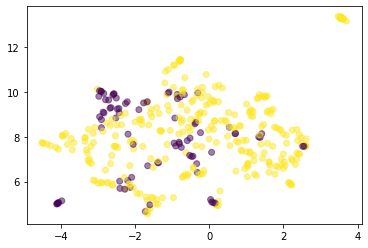

ValueError: 'c' argument must be a color, a sequence of colors, or a sequence of numbers, not 0      yes
1       no
2       no
3       no
4       no
      ... 
375     no
376     no
377     no
378     no
379     no
Name: label, Length: 380, dtype: object

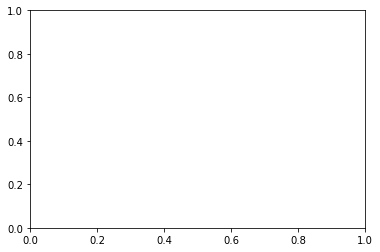

In [56]:
plt.scatter(umap_vecs[:, 0], umap_vecs[:, 1], c=a['label'])

In [35]:
from sentence_transformers import SentenceTransformer

In [36]:
model = SentenceTransformer('distilbert-base-uncased')

2021-07-06 16:30:52,451 - sentence_transformers.SentenceTransformer - INFO - Load pretrained SentenceTransformer: distilbert-base-uncased
2021-07-06 16:30:52,453 - root - WARNING - No sentence-transformers model found with name /home/ubuntu/.cache/torch/sentence_transformers/distilbert-base-uncased. Creating a new one with MEAN pooling.


Some weights of the model checkpoint at /home/ubuntu/.cache/torch/sentence_transformers/distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


2021-07-06 16:30:53,026 - sentence_transformers.SentenceTransformer - INFO - Use pytorch device: cuda


In [ ]:
dataset = sort_by_char_len(self.train_set)
samples = [Sample(**x) for x in dataset]
self.dataset = IterableDataset(samples, self.tokenizer, self.config["encode"])

model_config = self.config["model"]
model_config["num_labels"] = self.preproc_run.data.n_labels
logger.info('Loading pre-trained model')
model = partial(model_init, model_config)
training_args_config = self.config["training_args"]

training_args = TrainingArguments(**training_args_config)
trainer = Trainer(
        model=model(self.freeze_model),
        args=training_args,
        train_dataset=self.train_dataset,
        eval_dataset=self.eval_dataset,
        compute_metrics=compute_metrics,
        data_collator=BatchCollator(self.tokenizer)
        )
logger.info(f'Training model with {len(self.train_dataset)} samples')
trainer.train()
self.model = trainer.model


In [55]:
encodings = model.encode(df['Text'])

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

In [12]:
from umap import UMAP

In [13]:
from sklearn.decomposition import TruncatedSVD

In [38]:
def umapify(vectors):
    svd_transformer = TruncatedSVD(n_components=30)
    svd_vecs = svd_transformer.fit_transform(vectors)
    umap_transformer = UMAP(n_components=2)
    umap_vecs = umap_transformer.fit_transform(svd_vecs)
    return umap_vecs

In [56]:
umap_vecs = umapify(encodings)

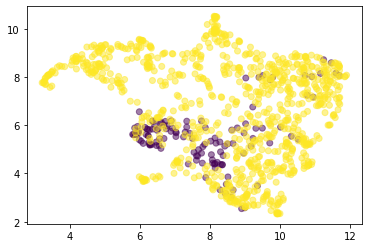

In [57]:
plt.scatter(umap_vecs[:, 0], umap_vecs[:, 1], c=[0 if l == 'Yes' else 1 for l in df.Label], alpha=.5)

In [58]:
X_train, X_test, y_train, y_test = train_test_split(encodings, df.Label, test_size=0.25)

In [59]:
clf = RandomForestClassifier()
clf.fit(X_train, y_train)

RandomForestClassifier()

In [60]:
preds = clf.predict(X_test)

In [61]:
from sklearn.metrics import classification_report

In [62]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

          No       0.90      0.98      0.94       223
         Yes       0.69      0.28      0.40        32

    accuracy                           0.89       255
   macro avg       0.80      0.63      0.67       255
weighted avg       0.88      0.89      0.87       255

